In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
df_ratings = pd.read_csv('./datos/rating_final.csv')
df_places = pd.read_csv('./datos/geoplaces2.csv')

datasets_locales = ['./datos/chefmozaccepts.csv', './datos/chefmozcuisine.csv', './datos/chefmozhours4.csv', './datos/chefmozparking.csv']

for dataset in datasets_locales:
    df_temp = pd.read_csv(dataset)
    merged_places = pd.merge(df_places, df_temp, on='placeID', how='left')

print(f"Shape del DataFrame original de locales: {merged_places.shape}")

merged_places = df_places.drop_duplicates(subset=['placeID'])

merged_places.to_csv('./datos/dataLocal.csv', sep=';', index=False)

for dataset in datasets_locales:
    df_temp = pd.read_csv(dataset)
    df_places = pd.merge(df_places, df_temp, on='placeID', how='left')

avg_ratings = df_ratings.groupby('placeID')[['rating', 'food_rating', 'service_rating']].mean().reset_index()

df_places = pd.merge(df_places, avg_ratings, on='placeID', how='left')
df_places = df_places.drop_duplicates(subset=['placeID'])
df_places.to_csv('./datos/dataLocal_with_averages.csv', sep=';', index=False)

print(f"Shape del DataFrame final de locales con promedios: {df_places.shape}")

Shape del DataFrame original de locales: (130, 22)
Shape del DataFrame final de locales con promedios: (130, 29)


In [3]:
userprofile_file = './datos/userprofile.csv'
usercuisine_file = './datos/usercuisine.csv'
userpayment_file = './datos/userpayment.csv'

df_userprofile = pd.read_csv(userprofile_file, sep=',')
df_usercuisine = pd.read_csv(usercuisine_file, sep=',')
df_userpayment = pd.read_csv(userpayment_file, sep=',')

df_users = pd.merge(df_userprofile, df_usercuisine, on='userID', how='left')
df_users = pd.merge(df_users, df_userpayment, on='userID', how='left')

df_users = df_users.drop_duplicates(subset=['userID'])

avg_user_ratings = df_ratings.groupby('userID')[['rating', 'food_rating', 'service_rating']].mean().reset_index()

df_users = pd.merge(df_users, avg_user_ratings, on='userID', how='left')

df_users.to_csv('./datos/dataUser.csv', sep=';', index=False)

print(f"Shape del DataFrame original de usuarios: {df_users.shape}")

Shape del DataFrame original de usuarios: (138, 24)


In [4]:
ratings = df_users
locales = df_places

In [7]:
locales.columns

Index(['placeID', 'latitude', 'longitude', 'the_geom_meter', 'name', 'address',
       'city', 'state', 'country', 'fax', 'zip', 'alcohol', 'smoking_area',
       'dress_code', 'accessibility', 'price', 'url', 'Rambience', 'franchise',
       'area', 'other_services', 'Rpayment', 'Rcuisine', 'hours', 'days',
       'parking_lot', 'rating', 'food_rating', 'service_rating'],
      dtype='object')

# EDA

## Locales

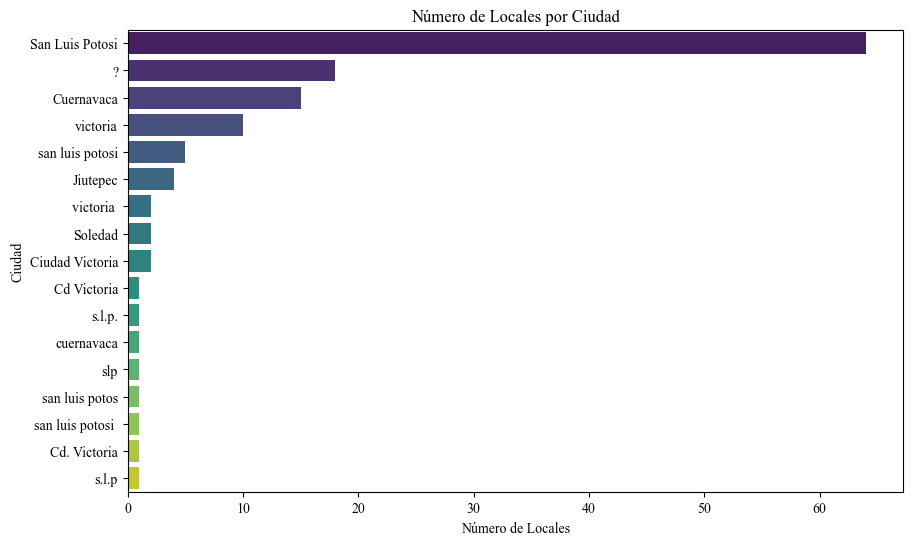

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

city_counts = locales['city'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=city_counts.values, y=city_counts.index, palette='viridis')
plt.title('Número de Locales por Ciudad')
plt.xlabel('Número de Locales')
plt.ylabel('Ciudad')
plt.show()

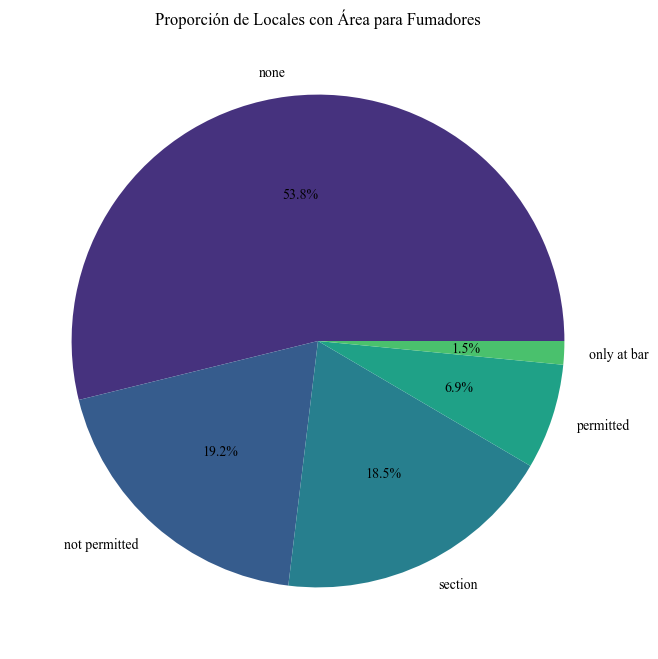

In [25]:
smoking_area_counts = locales['smoking_area'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(smoking_area_counts, labels=smoking_area_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title('Proporción de Locales con Área para Fumadores')
plt.show()

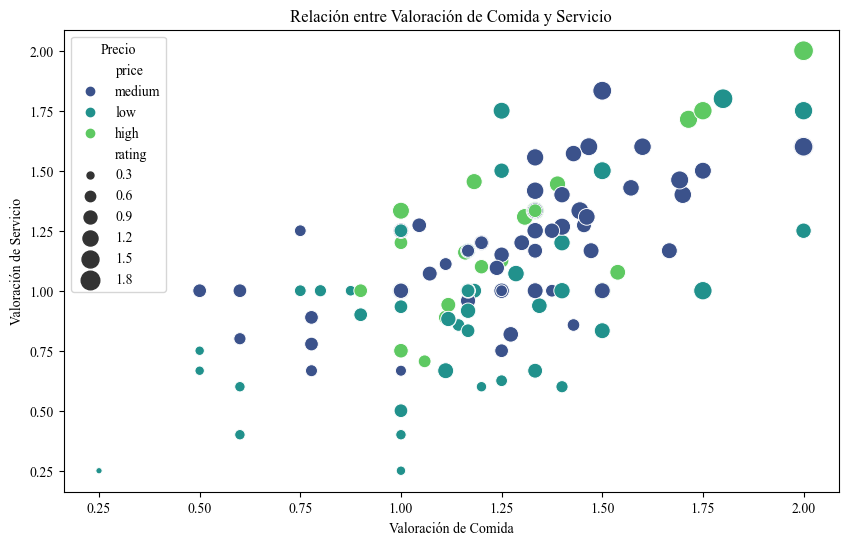

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=locales, x='food_rating', y='service_rating', hue='price', palette='viridis', size='rating', sizes=(20, 200))
plt.title('Relación entre Valoración de Comida y Servicio')
plt.xlabel('Valoración de Comida')
plt.ylabel('Valoración de Servicio')
plt.legend(title='Precio')
plt.show()

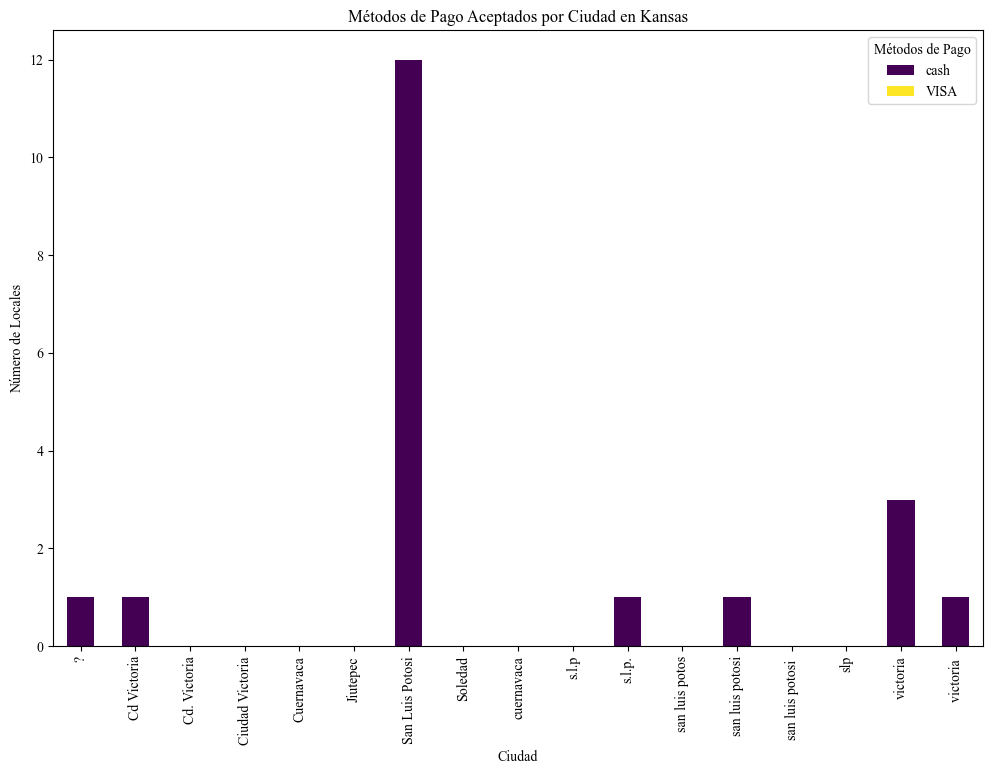

In [27]:
locales['Rpayment_list'] = locales['Rpayment'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

all_payments = [item for sublist in locales['Rpayment_list'] for item in sublist]
unique_payments = pd.Series(all_payments).value_counts().index

payment_df = pd.DataFrame(0, index=locales.index, columns=unique_payments)
for i, payments in enumerate(locales['Rpayment_list']):
    for payment in payments:
        if payment in payment_df.columns:
            payment_df.at[i, payment] = 1

payment_sums = payment_df.groupby(locales['city']).sum()

payment_sums.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Métodos de Pago Aceptados por Ciudad en Kansas')
plt.xlabel('Ciudad')
plt.ylabel('Número de Locales')
plt.legend(title='Métodos de Pago')
plt.show()

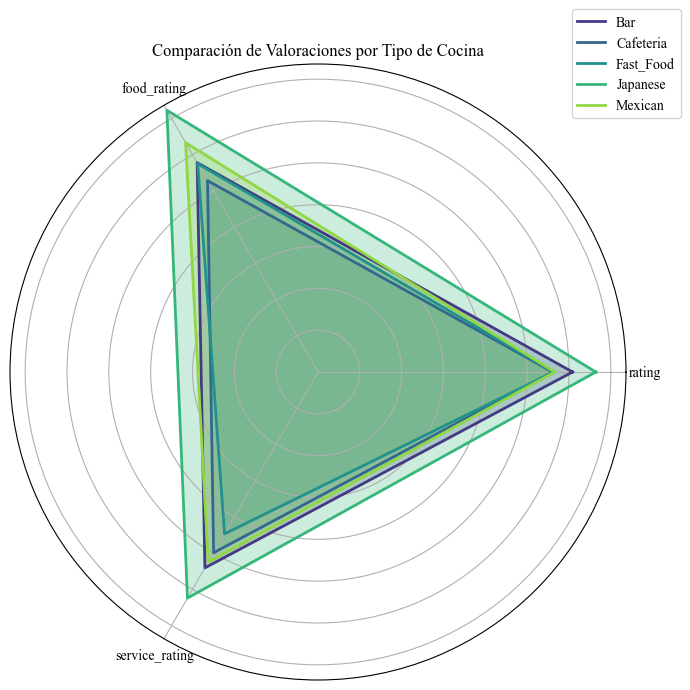

In [25]:
popular_cuisines = locales['Rcuisine'].value_counts().index[:5]
radar_data = locales[locales['Rcuisine'].isin(popular_cuisines)]

avg_ratings = radar_data.groupby('Rcuisine')[['rating', 'food_rating', 'service_rating']].mean()

labels = avg_ratings.columns
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = sns.color_palette('viridis', len(popular_cuisines))

for i, (cuisine, row) in enumerate(avg_ratings.iterrows()):
    values = row.tolist()
    values += values[:1]
    ax.fill(angles, values, color=colors[i], alpha=0.25)
    ax.plot(angles, values, color=colors[i], linewidth=2, label=cuisine)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title('Comparación de Valoraciones por Tipo de Cocina')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

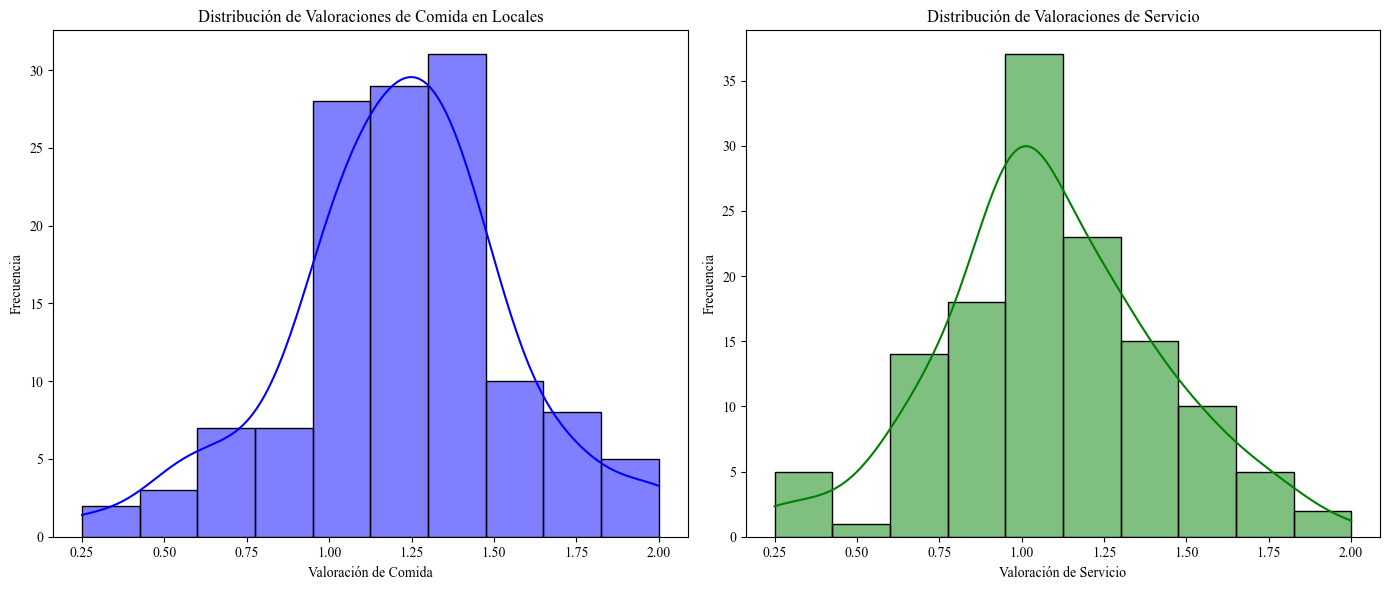

In [27]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(locales['food_rating'], bins=10, kde=True, color='blue')
plt.title('Distribución de Valoraciones de Comida en Locales')
plt.xlabel('Valoración de Comida')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.histplot(locales['service_rating'], bins=10, kde=True, color='green')
plt.title('Distribución de Valoraciones de Servicio')
plt.xlabel('Valoración de Servicio')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

## Usuarios

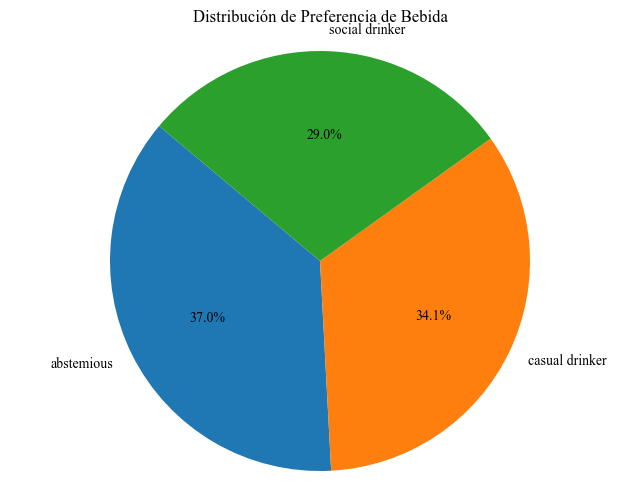

In [30]:
drink_counts = ratings['drink_level'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(drink_counts, labels=drink_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Preferencia de Bebida')
plt.axis('equal')  
plt.show()

/var/folders/22/kk3jgz8n1yn0zwh0vft67d040000gn/T/ipykernel_79660/3549005729.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratings['weight'], shade=True)


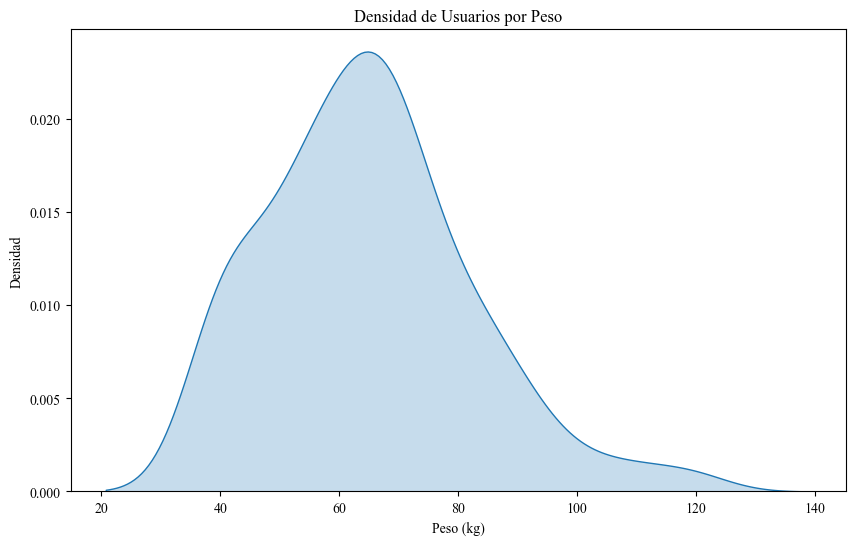

In [31]:
plt.figure(figsize=(10, 6))
sns.kdeplot(ratings['weight'], shade=True)
plt.title('Densidad de Usuarios por Peso')
plt.xlabel('Peso (kg)')
plt.ylabel('Densidad')
plt.show()

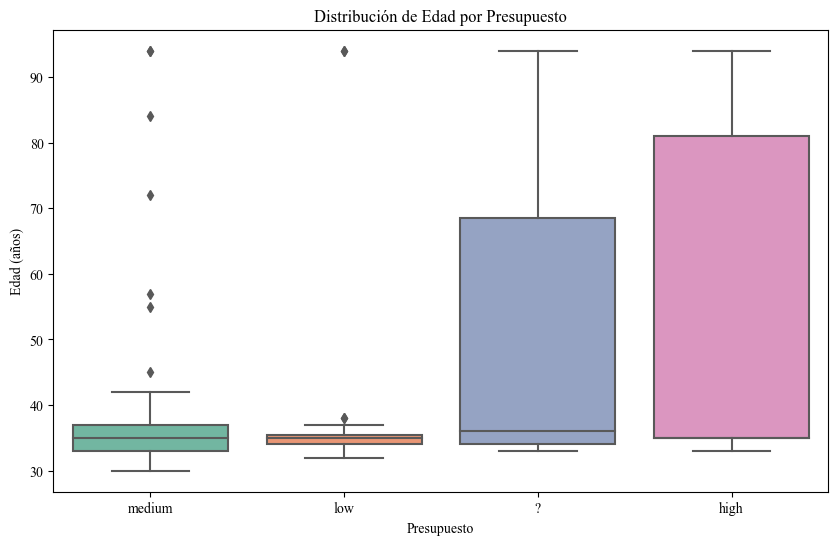

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=ratings['budget'], y=2024 - ratings['birth_year'], palette='Set2')
plt.title('Distribución de Edad por Presupuesto')
plt.xlabel('Presupuesto')
plt.ylabel('Edad (años)')
plt.show()

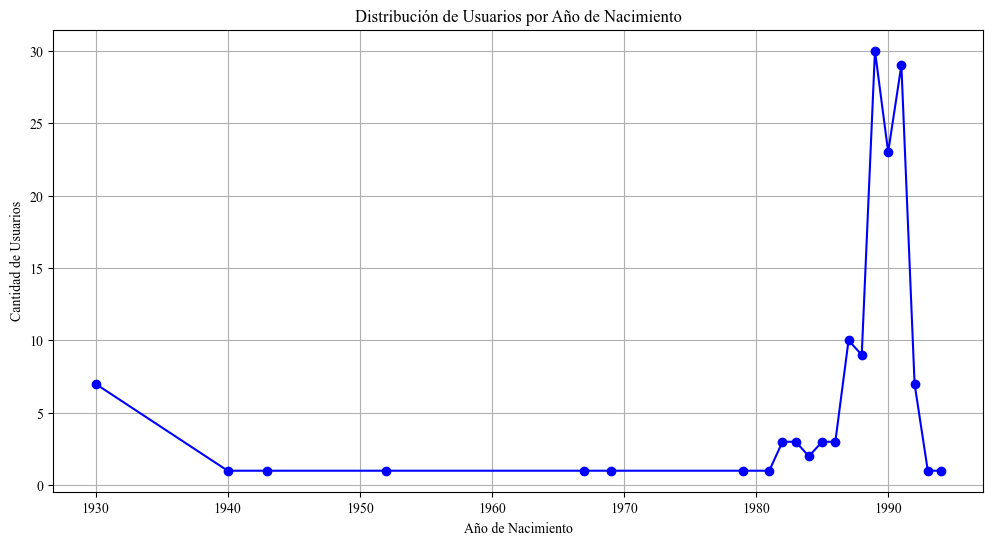

In [33]:
birth_year_counts = ratings['birth_year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(birth_year_counts.index, birth_year_counts.values, marker='o', linestyle='-', color='b')
plt.title('Distribución de Usuarios por Año de Nacimiento')
plt.xlabel('Año de Nacimiento')
plt.ylabel('Cantidad de Usuarios')
plt.grid(True)
plt.show()

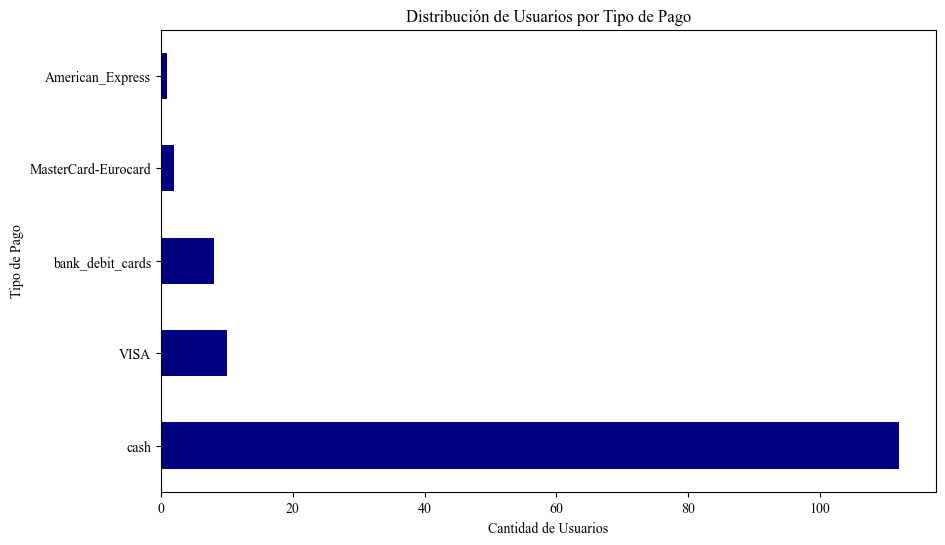

In [34]:
payment_counts = ratings['Upayment'].value_counts()

plt.figure(figsize=(10, 6))
payment_counts.plot(kind='barh', color='navy')
plt.title('Distribución de Usuarios por Tipo de Pago')
plt.xlabel('Cantidad de Usuarios')
plt.ylabel('Tipo de Pago')
plt.show()

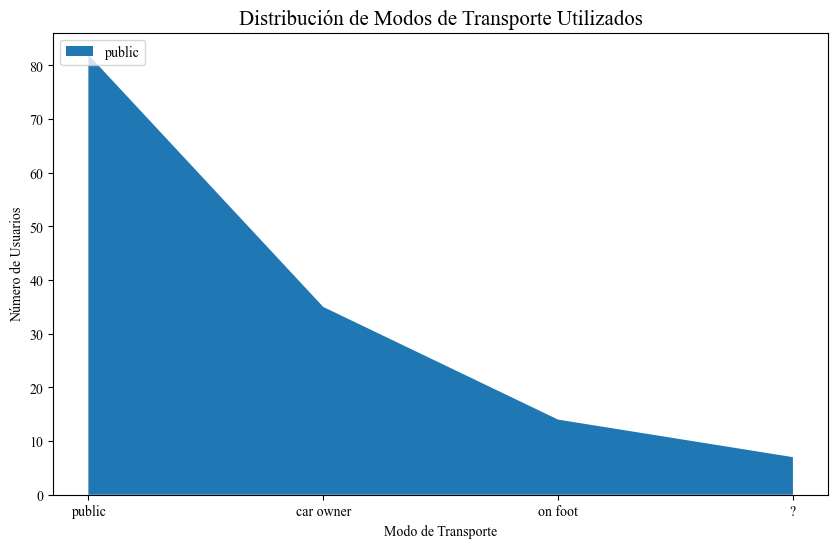

In [35]:
transport_counts = ratings['transport'].value_counts()

plt.figure(figsize=(10, 6))
plt.stackplot(transport_counts.index, transport_counts.values, labels=transport_counts.index)
plt.title('Distribución de Modos de Transporte Utilizados', size=15)
plt.xlabel('Modo de Transporte')
plt.ylabel('Número de Usuarios')
plt.legend(loc='upper left')
plt.show()

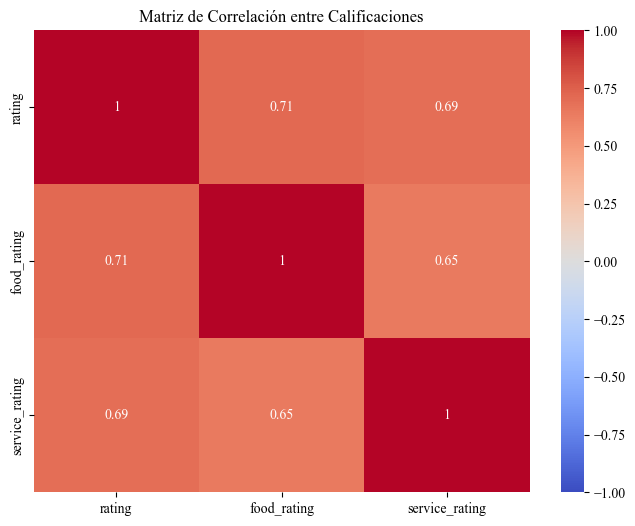

In [36]:
correlation_matrix = df_ratings[['rating', 'food_rating', 'service_rating']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación entre Calificaciones')
plt.show()